In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Project paths
PROJECT_ROOT = '/content/drive/MyDrive/SU Works/CPSC_5310_Project'
DATA_PATH = os.path.join(PROJECT_ROOT, 'saved_data')

# Input file (with clusters already assigned)
INPUT_FILE = os.path.join(DATA_PATH, 'clean_dataset_with_clusters.parquet')

# Output files
TRAIN_FILE = os.path.join(DATA_PATH, 'train_raw.parquet')
TEST_FILE = os.path.join(DATA_PATH, 'test_raw.parquet')

# Split configuration
TEST_START_DATE = '2016-03-14'  # Test set starts here

In [4]:
df = pd.read_parquet(INPUT_FILE)

In [5]:
if 'pickup_cluster' not in df.columns:
    raise ValueError("ERROR: 'pickup_cluster' column not found")

In [6]:
split_date = pd.Timestamp(TEST_START_DATE)

In [7]:
train_df = df[df['tpep_pickup_datetime'] < split_date].copy()
test_df = df[df['tpep_pickup_datetime'] >= split_date].copy()

In [8]:
# Calculate statistics
train_count = len(train_df)
test_count = len(test_df)
total_count = train_count + test_count

train_pct = (train_count / total_count) * 100
test_pct = (test_count / total_count) * 100

# Calculate date ranges
train_start = train_df['tpep_pickup_datetime'].min()
train_end = train_df['tpep_pickup_datetime'].max()
train_days = (train_end - train_start).days

test_start = test_df['tpep_pickup_datetime'].min()
test_end = test_df['tpep_pickup_datetime'].max()
test_days = (test_end - test_start).days

print(f"\n{'='*70}")
print(f"TRAINING SET")
print(f"{'='*70}")
print(f"Date range: {train_start} to {train_end}")
print(f"Duration: {train_days} days")
print(f"Total trips: {train_count:,}")
print(f"Percentage: {train_pct:.1f}%")
print(f"Avg trips/day: {train_count/train_days:,.0f}")

print(f"\n{'='*70}")
print(f"TEST SET")
print(f"{'='*70}")
print(f"Date range: {test_start} to {test_end}")
print(f"Duration: {test_days} days")
print(f"Total trips: {test_count:,}")
print(f"Percentage: {test_pct:.1f}%")
print(f"Avg trips/day: {test_count/test_days:,.0f}")

print(f"\n{'='*70}")
print(f"TOTAL")
print(f"{'='*70}")
print(f"Total trips: {total_count:,}")
print(f"Train + Test check: {train_count + test_count == len(df)}")


TRAINING SET
Date range: 2016-01-01 00:00:00 to 2016-03-13 23:59:59
Duration: 72 days
Total trips: 26,859,749
Percentage: 79.7%
Avg trips/day: 373,052

TEST SET
Date range: 2016-03-14 00:00:00 to 2016-03-31 23:59:59
Duration: 17 days
Total trips: 6,821,542
Percentage: 20.3%
Avg trips/day: 401,267

TOTAL
Total trips: 33,681,291
Train + Test check: True


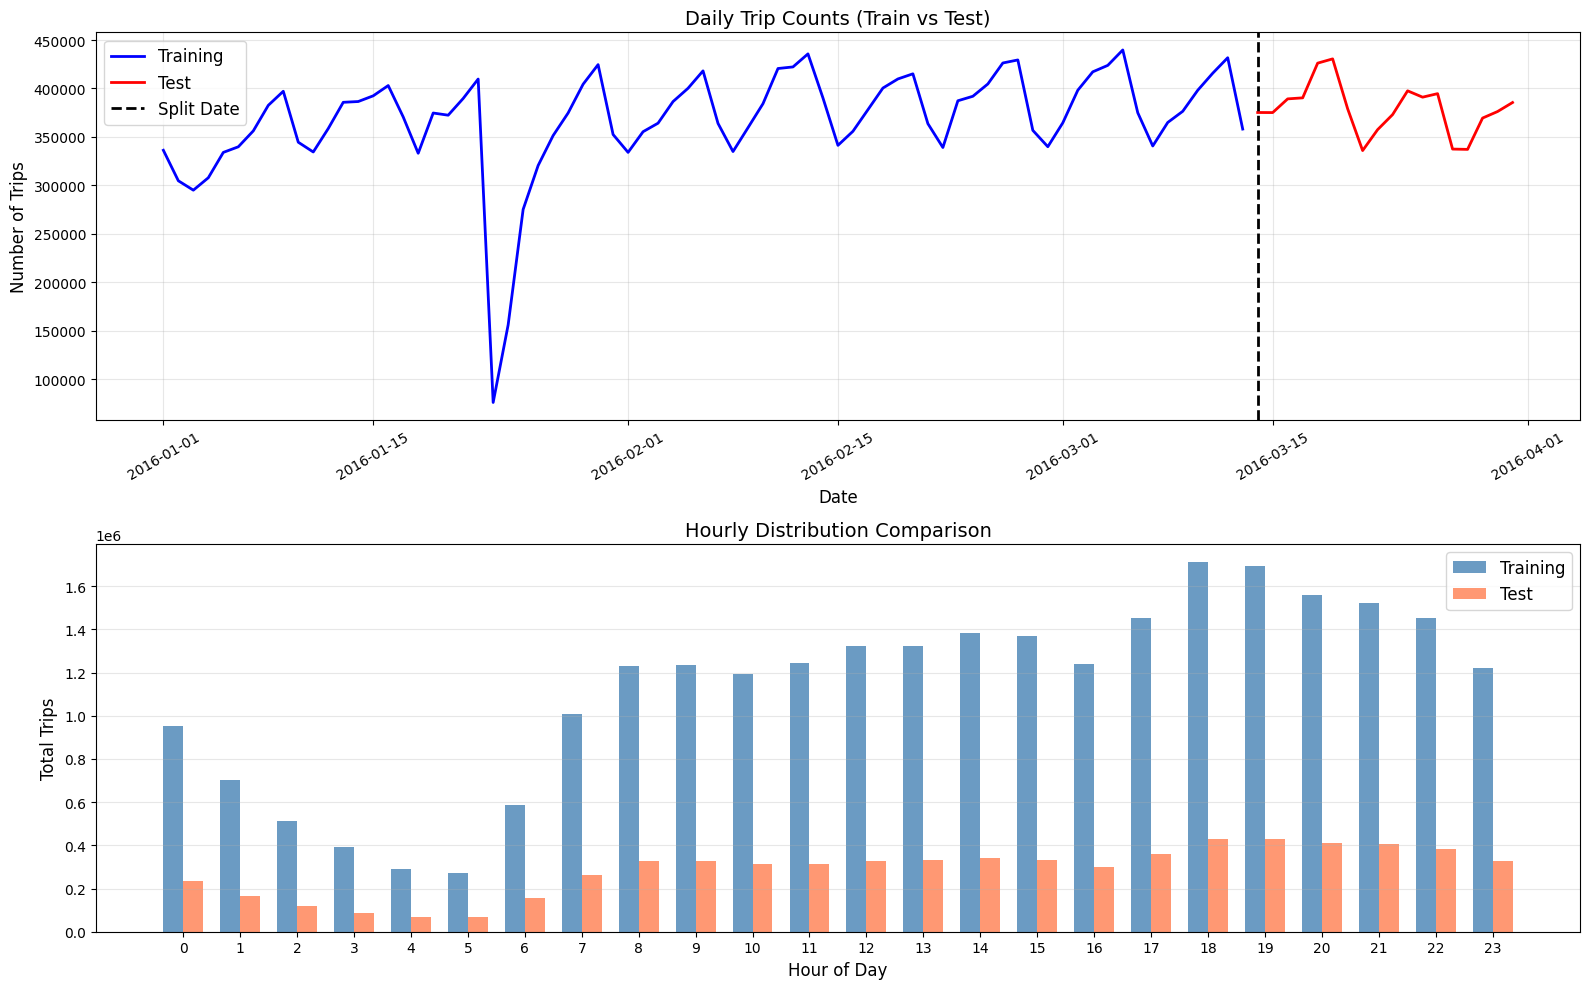

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 1. Daily trip counts
train_daily = train_df.groupby(train_df['tpep_pickup_datetime'].dt.date).size()
test_daily = test_df.groupby(test_df['tpep_pickup_datetime'].dt.date).size()

axes[0].plot(train_daily.index, train_daily.values, 'b-', label='Training', linewidth=2)
axes[0].plot(test_daily.index, test_daily.values, 'r-', label='Test', linewidth=2)
axes[0].axvline(x=pd.Timestamp(TEST_START_DATE).date(), color='black',
                   linestyle='--', linewidth=2, label='Split Date')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Trips', fontsize=12)
axes[0].set_title('Daily Trip Counts (Train vs Test)', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=30)

# 3. Hourly distribution comparison
train_hourly = train_df['tpep_pickup_datetime'].dt.hour.value_counts().sort_index()
test_hourly = test_df['tpep_pickup_datetime'].dt.hour.value_counts().sort_index()

x = np.arange(24)
width = 0.35

axes[1].bar(x - width/2, train_hourly.values, width, label='Training',
               color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, test_hourly.values, width, label='Test',
               color='coral', alpha=0.8)
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Total Trips', fontsize=12)
axes[1].set_title('Hourly Distribution Comparison', fontsize=14)
axes[1].set_xticks(x)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [10]:
train_df.to_parquet(TRAIN_FILE, index=False)
train_size_mb = os.path.getsize(TRAIN_FILE) / (1024 * 1024)
print(f"Training set saved ({train_size_mb:.1f} MB)")

test_df.to_parquet(TEST_FILE, index=False)
test_size_mb = os.path.getsize(TEST_FILE) / (1024 * 1024)
print(f"Test set saved ({test_size_mb:.1f} MB)")

Training set saved (784.2 MB)
Test set saved (199.5 MB)
